Multi-Driver Exploratory Data Analysis

This notebook engineers telemetry data from the Fast-F1 API for telemetry dataframes for multiple drivers. It utilizes a structured workflow for data acquisition, preparation, and further exploration prior applying machine learning models to multi-driver behavior analysis results. Descriptive statistics and visualization functions provide dynamic insights into the data to identify patterns or anomalies, and guide subsequent feature engineering and modeling decisions.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.WARNING)

In this section, I import Python libraries for data visualization, numerical analysis, and working with Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

The session parameters were chosen to best match Tier 1 control qualities:

- Weather: Abu Dhabi (clear, dry conditions)
- Max Speed: C5 Ultra Soft Tires
- Minimize Outliers: Qualifying Sessions (Q3 & Q2)
- Traffic: Avoid tow laps to avoid slipstream bias

In [3]:
year = 2024
grand_prix = f1_constants.F1Constants.LOCATIONS["Abu Dhabi"]
session_type = f1_constants.F1Constants.SESSIONS["Q"]

session = f1_data.F1Session(year, grand_prix, session_type)

req         WARNING 	DEFAULT CACHE ENABLED! (716.91 MB) /Users/phillipsmith/Library/Caches/fastf1
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '55', '27', '1', '10', '63', '14', '77', '11', '22', '30', '18', '16', '20', '23', '24', '44', '43', '61']


All drivers who participated in the specific location's Q2 and Q3 sessions will be analyzed and assigned variables to be identified by their three-letter name code. Q3 data will be used for each driver whenever available; otherwise, Q2 data will be selected.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

In [4]:
# driver constants
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
perez = f1_constants.F1Constants.DRIVERS["Sergio Perez"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
bottas = f1_constants.F1Constants.DRIVERS["Valtteri Bottas"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]
magnussen = f1_constants.F1Constants.DRIVERS["Kevin Magnussen"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]

The code extracts circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

# 16 --> 2500, 12 --> 1500
critical_turn = [16]
radius = 2500

corner_position_cleaned

,Turn,X (1/10 m),Y (1/10 m),Angle (°),Distance (1/10 m)
0,1,4294.859375,2690.717773,-35.340600,377.851945
1,2,3848.351318,4987.570801,42.198164,626.674566
2,3,2206.551025,6155.120117,-163.169332,834.459836
3,4,2378.656250,8052.805176,-8.298533,1009.587697
4,5,1839.358276,11771.707031,84.326847,1416.310910
5,6,-2150.159424,655.311096,-148.988037,2616.829683
6,7,-1583.492065,587.163330,46.320930,2677.365930
7,8,-823.991882,-1256.985107,-144.588429,2877.258977
8,9,5774.805664,-4917.836914,-21.958205,3682.011370
9,10,3125.774414,-3602.140381,82.890762,4026.195705


For each driver, the telemetry from their fastest qualifying lap is isolated by filtering based on sector timestamps. These sector datasets are then cleaned, enriched with derived features, and filtered by turn to focus on the segments most informative for analyzing driver behavior and responses in complex areas.

Q3 data for Lando Norris, McLaren

In [6]:
q1, q2, q3 = session.get_laps(norris).split_qualifying_sessions()
norris_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

norris_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_start, end=sector_1_end)
norris_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector1_telemetry, norris)

norris_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_end, end=sector_2_end)
norris_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector2_telemetry, norris)

norris_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_2_end, end=sector_3_end)
norris_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector3_telemetry, norris)
norris_sector3_telemetry_features = feature_engineering.TelemetryFeatures(norris_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

norris_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics — Lando Norris - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [7]:
norris_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
norris_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(norris, norris_turn_dfs)

Q3 data for Oscar Piastri, McLaren

In [8]:
q1, q2, q3 = session.get_laps(piastri).split_qualifying_sessions()
piastri_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

piastri_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_start, end=sector_1_end)
piastri_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector1_telemetry, piastri)

piastri_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_end, end=sector_2_end)
piastri_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector2_telemetry, piastri)

piastri_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_2_end, end=sector_3_end)
piastri_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector3_telemetry, piastri)
piastri_sector3_telemetry_features = feature_engineering.TelemetryFeatures(piastri_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

piastri_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Oscar Piastri - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [9]:
piastri_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
piastri_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(piastri, piastri_turn_dfs)

Q3 data for Max Verstappen, Red Bull

In [10]:
q1, q2, q3 = session.get_laps(verstappen).split_qualifying_sessions()
verstappen_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

verstappen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_start, end=sector_1_end)
verstappen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector1_telemetry, verstappen)

verstappen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_end, end=sector_2_end)
verstappen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector2_telemetry, verstappen)

verstappen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_2_end, end=sector_3_end)
verstappen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector3_telemetry, verstappen)
verstappen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(verstappen_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

verstappen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)


Descriptive Statistics - Max Verstappen - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [11]:
verstappen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
verstappen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(verstappen, verstappen_turn_dfs)

Q3 data for Sergio Perez, Red Bull

In [12]:
q1, q2, q3 = session.get_laps(perez).split_qualifying_sessions()
perez_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

perez_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_start, end=sector_1_end)
perez_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector1_telemetry, perez)

perez_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_end, end=sector_2_end)
perez_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector2_telemetry, perez)

perez_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_2_end, end=sector_3_end)
perez_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector3_telemetry, perez)
perez_sector3_telemetry_features = feature_engineering.TelemetryFeatures(perez_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

perez_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Sergio Perez - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [13]:
perez_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
perez_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(perez, perez_turn_dfs)

Q3 data for Carlos Sainz, Ferrari

In [14]:
q1, q2, q3 = session.get_laps(sainz).split_qualifying_sessions()
sainz_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

sainz_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_start, end=sector_1_end)
sainz_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector1_telemetry, sainz)

sainz_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_end, end=sector_2_end)
sainz_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector2_telemetry, sainz)

sainz_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_2_end, end=sector_3_end)
sainz_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector3_telemetry, sainz)
sainz_sector3_telemetry_features = feature_engineering.TelemetryFeatures(sainz_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

sainz_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Carlos Sainz - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [15]:
sainz_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
sainz_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(sainz, sainz_turn_dfs)

Q2 data for Charles Leclerc, Ferrari

In [16]:
q1, q2, q3 = session.get_laps(leclerc).split_qualifying_sessions()
leclerc_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

leclerc_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_start, end=sector_1_end)
leclerc_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector1_telemetry, leclerc)

leclerc_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_end, end=sector_2_end)
leclerc_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector2_telemetry, leclerc)

leclerc_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_2_end, end=sector_3_end)
leclerc_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector3_telemetry, leclerc)
leclerc_sector3_telemetry_features = feature_engineering.TelemetryFeatures(leclerc_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

leclerc_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Charles Leclerc - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [17]:
leclerc_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
leclerc_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(leclerc, leclerc_turn_dfs)

Q3 data for Valtteri Bottas, Alfa Romeo

In [18]:
q1, q2, q3 = session.get_laps(bottas).split_qualifying_sessions()
bottas_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

bottas_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_start, end=sector_1_end)
bottas_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector1_telemetry, bottas)

bottas_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_end, end=sector_2_end)
bottas_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector2_telemetry, bottas)

bottas_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_2_end, end=sector_3_end)
bottas_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector3_telemetry, bottas)
bottas_sector3_telemetry_features = feature_engineering.TelemetryFeatures(bottas_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

bottas_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Valtteri Bottas - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [19]:
bottas_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
bottas_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(bottas, bottas_turn_dfs)

Q3 data for Fernando Alonso, Aston Martin

In [20]:
q1, q2, q3 = session.get_laps(alonso).split_qualifying_sessions()
alonso_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

alonso_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_start, end=sector_1_end)
alonso_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector1_telemetry, alonso)

alonso_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_end, end=sector_2_end)
alonso_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector2_telemetry, alonso)

alonso_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_2_end, end=sector_3_end)
alonso_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector3_telemetry, alonso)
alonso_sector3_telemetry_features = feature_engineering.TelemetryFeatures(alonso_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

alonso_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Fernando Alonso - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [21]:
alonso_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
alonso_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(alonso, alonso_turn_dfs)

Q2 data for Lance Stroll, Aston Martin

In [22]:
q1, q2, q3 = session.get_laps(stroll).split_qualifying_sessions()
stroll_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

stroll_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_start, end=sector_1_end)
stroll_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector1_telemetry, stroll)

stroll_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_end, end=sector_2_end)
stroll_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector2_telemetry, stroll)

stroll_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_2_end, end=sector_3_end)
stroll_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector3_telemetry, stroll)
stroll_sector3_telemetry_features = feature_engineering.TelemetryFeatures(stroll_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

stroll_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Lance Stroll - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [23]:
stroll_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
stroll_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(stroll, stroll_turn_dfs)

Q3 data for Pierre Gasly, Alpine

In [24]:
q1, q2, q3 = session.get_laps(gasly).split_qualifying_sessions()
gasly_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

gasly_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_start, end=sector_1_end)
gasly_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector1_telemetry, gasly)

gasly_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_end, end=sector_2_end)
gasly_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector2_telemetry, gasly)

gasly_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_2_end, end=sector_3_end)
gasly_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector3_telemetry, gasly)
gasly_sector3_telemetry_features = feature_engineering.TelemetryFeatures(gasly_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

gasly_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)
gasly_corner_telemetry

,DriverCode,SessionTime (s),SectorTime (s),RPM,Speed (m/s),Acceleration (m/s²),Jerk (m/s³),G-force (g),nGear,Throttle (%),BrakesApplied,Distance (m),X (1/10 m),Y (1/10 m),Z (1/10 m)
8405,GAS,0 days 01:17:32.475000,0 days 00:18:15.335000,11236.683396,69.020889,3.472223,-1.909911e+00,0.354068,6,100.000000,0,25737.862302,470.000000,-242.000000,-230.000000
8406,GAS,0 days 01:17:32.677000,0 days 00:18:15.537000,11336.000000,69.722278,3.086421,1.698994e-05,0.314727,6,100.000000,0,25751.960278,373.350537,-255.182649,-228.346296
8407,GAS,0 days 01:17:32.814000,0 days 00:18:15.674000,11429.616623,70.145118,3.086423,-3.460130e+00,0.314728,6,100.000000,0,25761.614245,317.000000,-259.000000,-227.000000
8408,GAS,0 days 01:17:33.037000,0 days 00:18:15.897000,11582.000000,70.833390,2.314814,8.867699e-05,0.236045,6,100.000000,0,25777.460278,173.260351,-261.022599,-223.777441
8409,GAS,0 days 01:17:33.094000,0 days 00:18:15.954000,11606.383306,70.965334,2.314819,-2.698429e-05,0.236046,6,100.000000,0,25781.528462,126.000000,-255.000000,-223.000000
8410,GAS,0 days 01:17:33.275000,0 days 00:18:16.135000,11683.811166,71.384317,2.314814,-4.743457e+00,0.236045,6,100.000000,0,25794.492446,-39.000000,-216.000000,-221.000000
8411,GAS,0 days 01:17:33.397000,0 days 00:18:16.257000,11736.000000,71.666724,1.736113,-3.293034e-13,0.177034,6,100.000000,0,25803.260278,-122.123768,-190.037265,-220.022027
8412,GAS,0 days 01:17:33.633000,0 days 00:18:16.493000,10735.950000,72.076447,1.736112,2.952561e+00,0.177034,6,100.000000,0,25820.283087,-240.000000,-133.000000,-219.000000
8413,GAS,0 days 01:17:33.717000,0 days 00:18:16.577000,10380.000000,72.222280,1.984128,1.324740e-05,0.202325,7,100.000000,0,25826.371389,-288.860420,-102.515532,-218.932598
8414,GAS,0 days 01:17:33.854000,0 days 00:18:16.714000,10359.939295,72.494105,1.984129,-2.081254e+01,0.202325,7,100.000000,0,25836.340336,-369.000000,-46.000000,-219.000000


Descriptive Statistics - Pierre Gasly - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [25]:
gasly_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
gasly_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(gasly, gasly_turn_dfs)

Q3 data for Nico Hulkenberg, Haas

In [26]:
q1, q2, q3 = session.get_laps(hulkenberg).split_qualifying_sessions()
hulkenberg_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

hulkenberg_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_start, end=sector_1_end)
hulkenberg_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector1_telemetry, hulkenberg)

hulkenberg_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_end, end=sector_2_end)
hulkenberg_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector2_telemetry, hulkenberg)

hulkenberg_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_2_end, end=sector_3_end)
hulkenberg_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector3_telemetry, hulkenberg)
hulkenberg_sector3_telemetry_features = feature_engineering.TelemetryFeatures(hulkenberg_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

hulkenberg_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Nico Hulkenberg - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [27]:
hulkenberg_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
hulkenberg_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(hulkenberg, hulkenberg_turn_dfs)

Q2 data for Kevin Magnussen, Haas

In [28]:
q1, q2, q3 = session.get_laps(magnussen).split_qualifying_sessions()
magnussen_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

magnussen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_start, end=sector_1_end)
magnussen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector1_telemetry, magnussen)

magnussen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_end, end=sector_2_end)
magnussen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector2_telemetry, magnussen)

magnussen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_2_end, end=sector_3_end)
magnussen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector3_telemetry, magnussen)
magnussen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(magnussen_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

magnussen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Kevin Magnussen - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [29]:
magnussen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
magnussen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(magnussen, magnussen_turn_dfs)

Q2 data for Liam Lawson, Visa CashApp

In [30]:
q1, q2, q3 = session.get_laps(lawson).split_qualifying_sessions()
lawson_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

lawson_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_start, end=sector_1_end)
lawson_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector1_telemetry, lawson)

lawson_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_end, end=sector_2_end)
lawson_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector2_telemetry, lawson)

lawson_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_2_end, end=sector_3_end)
lawson_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector3_telemetry, lawson)
lawson_sector3_telemetry_features = feature_engineering.TelemetryFeatures(lawson_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

lawson_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Liam Lawson - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [31]:
lawson_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
lawson_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(lawson, lawson_turn_dfs)

Q2 data for Yuki Tsunoda, Visa CashApp

In [32]:
q1, q2, q3 = session.get_laps(tsunoda).split_qualifying_sessions()
tsunoda_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

tsunoda_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_start, end=sector_1_end)
tsunoda_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector1_telemetry, tsunoda)

tsunoda_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_end, end=sector_2_end)
tsunoda_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector2_telemetry, tsunoda)

tsunoda_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_2_end, end=sector_3_end)
tsunoda_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector3_telemetry, tsunoda)
tsunoda_sector3_telemetry_features = feature_engineering.TelemetryFeatures(tsunoda_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

tsunoda_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - Yuki Tsunoda - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [33]:
tsunoda_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
tsunoda_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(tsunoda, tsunoda_turn_dfs)

Q3 data for George Russell, Mercedes

In [34]:
q1, q2, q3 = session.get_laps(russell).split_qualifying_sessions()
russell_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

russell_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_start, end=sector_1_end)
russell_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector1_telemetry, russell)

russell_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_end, end=sector_2_end)
russell_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector2_telemetry, russell)

russell_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_2_end, end=sector_3_end)
russell_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector3_telemetry, russell)
russell_sector3_telemetry_features = feature_engineering.TelemetryFeatures(russell_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

russell_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

Descriptive Statistics - George Russell - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [35]:
russell_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
russell_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(russell, russell_turn_dfs)

Descriptive Statistics - All Drivers - The following code concatenates descriptive statistics for each driver into a single DataFrame for downstream visualization comparison.

In [36]:
all_driver_eda_summaries = pd.concat([
    norris_eda_summary, 
    piastri_eda_summary,
    verstappen_eda_summary,
    perez_eda_summary,
    sainz_eda_summary,
    leclerc_eda_summary,
    bottas_eda_summary,
    alonso_eda_summary,
    stroll_eda_summary,
    gasly_eda_summary,
    hulkenberg_eda_summary,
    magnussen_eda_summary,
    lawson_eda_summary,
    tsunoda_eda_summary,
    russell_eda_summary
    ])

all_driver_eda_summaries

,Driver,Turn,Row Count,Max Speed,Mean Speed,Median Speed,SD Speed,Max Accel,Mean Accel,Median Accel,SD Accel,Max Jerk,Mean Jerk,Median Jerk,SD Jerk,Max Gs,Mean Gs,Median Gs,SD Gs,Gear Shifts,Throttle Events,Mean Throttle,SD Throttle,Brake Events
0,NOR,16,63,75.277838,57.344982,57.222268,13.565218,16.666680,-0.661309,2.314787,12.658388,2893.563761,43.179675,-1.087565e-13,382.210859,4.602889,0.878407,0.619619,0.941664,4,2,69.613554,42.409431,1
0,PIA,16,67,75.277838,57.537776,59.168099,13.741954,12.345689,-0.780020,2.083335,11.235878,2083.112778,56.302140,1.233581e-13,326.334141,3.068595,0.850449,0.708137,0.764802,5,2,66.941419,43.447465,1
0,VER,16,62,75.000060,55.634601,53.408607,14.003103,11.904771,-1.180369,1.736114,11.893096,17731.323620,517.491471,4.615303e-05,2659.301740,3.934345,0.791087,0.531103,0.921645,4,2,69.351849,41.448633,1
0,PER,16,64,74.444504,55.772932,56.027389,13.757684,13.889196,-0.468533,2.893515,13.122799,1519.097022,10.139750,1.962648e-05,269.502697,3.717724,0.988737,0.786820,0.894346,3,2,70.301491,42.023627,1
0,SAI,16,64,75.833394,57.178967,58.333380,14.391193,17.857162,0.032434,2.314817,11.759878,552.403137,-22.779047,-5.285221e-13,201.569569,3.540684,0.848876,0.578312,0.840239,4,2,71.658061,41.908480,1
0,LEC,16,63,76.111172,57.834744,58.333380,14.015042,15.625013,0.126180,2.604169,13.469746,165.344552,1.055976,1.297663e-14,64.061786,5.979823,0.820361,0.472091,1.096773,5,1,76.715560,35.828167,1
0,BOT,16,65,74.444504,57.549441,59.166714,13.680308,14.983879,-0.488292,1.388891,13.621176,1774.750391,37.859323,0.000000e+00,229.649207,4.868446,0.879529,0.472091,1.070564,4,2,75.164263,38.759111,1
0,ALO,16,63,74.722282,57.916230,59.972270,13.422748,13.888939,-0.748079,1.984129,13.414703,2314.766131,47.916282,3.552714e-13,316.063358,3.806235,0.922534,0.708137,1.006141,6,3,70.742826,41.056510,1
0,STR,16,61,74.444504,57.482511,58.333380,13.941375,15.625013,-0.430441,1.736113,13.805450,661.376190,15.956253,1.320992e-05,94.039194,5.355066,0.901784,0.606975,1.075635,4,3,73.034914,41.079768,1
0,GAS,16,66,74.166726,57.621776,58.843301,13.281316,13.117298,-2.272275,2.149472,14.489769,179.597697,9.517023,1.631841e-05,52.449046,4.956962,0.959210,0.655794,1.141672,5,2,69.371300,42.447647,1


Visualizations - Multiple Drivers - This multi-axis plot can dynamically display telemetry data to reveal unique driver performance for given driver dataframes.
Limit the number of features to maintain clarity.

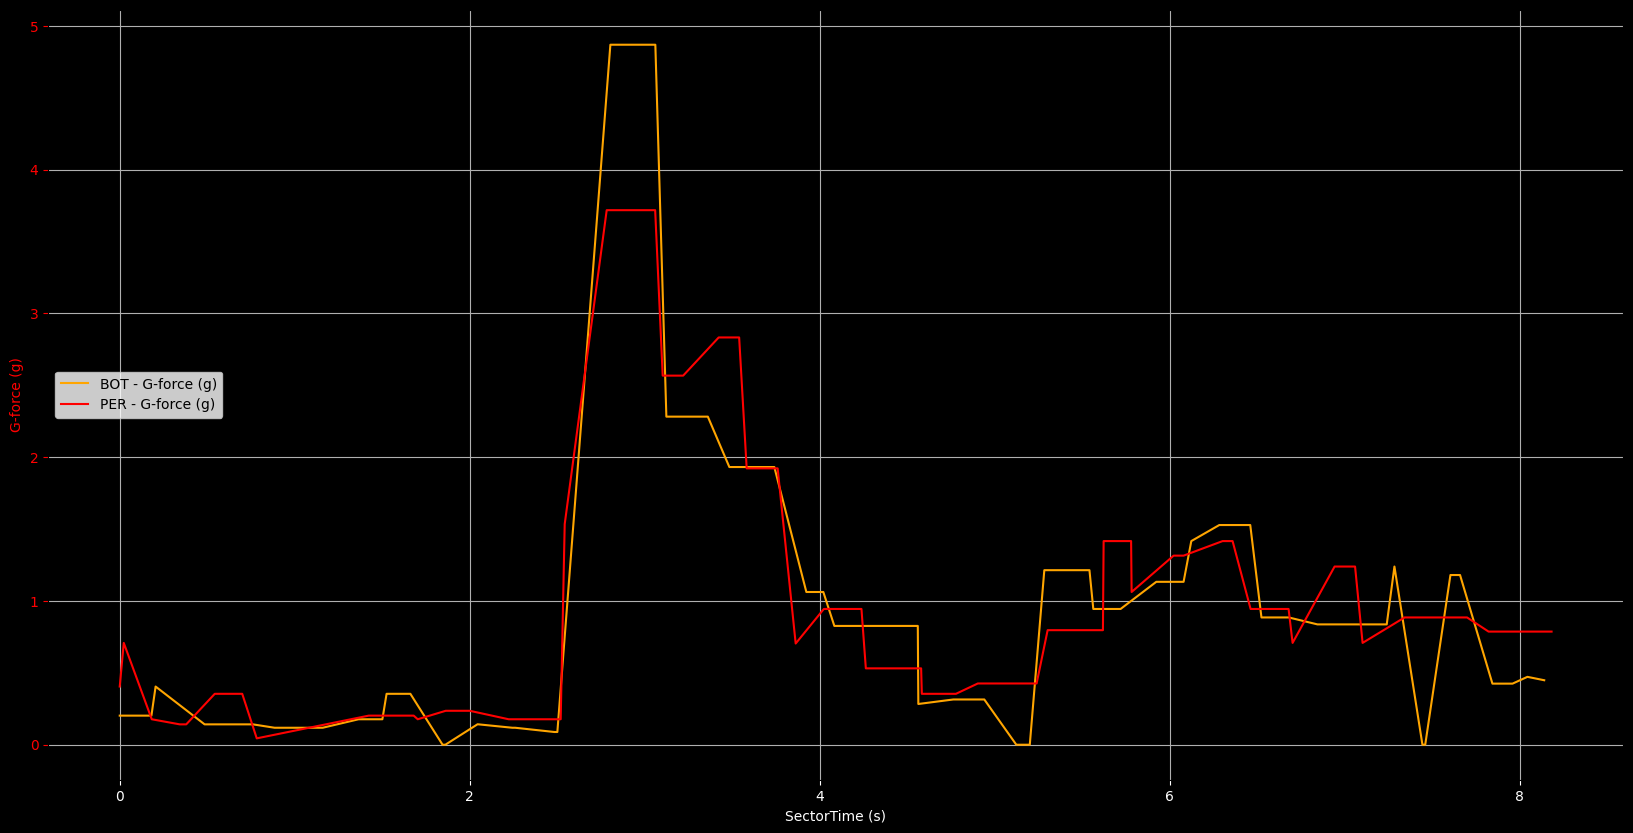

In [37]:
plots.plot_multiple_drivers_telemetry(dfs=[bottas_corner_telemetry, perez_corner_telemetry], 
                                      drivers=[bottas, perez],
                                      time_col='SectorTime (s)', 
                                      telemetry_cols=[g_force])